# Nested turbine type specific optimization

In this example, a nested optimization is performed accounting for the layout and the turbine types. The inner layer solves the layout optimization problem with a gradient-based solver, and the outer layer changes the turbine types with a gradient-free (random-search) solver. In this case, the boundaries are not specific to the wind turbine and a spacing and circular boundary contraints are used.

The objective function is to minimize the wake losses produced by neighbouring wind turbines.

**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

Loading Python dependencies.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Loading PyWake dependencies. We import the two turbines to use (Vestas V80 and the DTU 10MW reference turbine) as well as the site (IEA37) and the wake deficit model (IEA37SimpleBastankhahGaussian) to use for the optimization.

In [ ]:
from py_wake.examples.data.iea37._iea37 import IEA37Site
from py_wake.wind_turbines import WindTurbines
from py_wake.examples.data.hornsrev1 import V80
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.utils.gradients import autograd

Loading TOPFARM dependencies.

In [ ]:
import topfarm
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver
from topfarm.drivers.random_search_driver import randomize_turbine_type
from topfarm.constraint_components.boundary import CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint, SpacingTypeConstraint
from topfarm.plotting import XYPlotComp, TurbineTypePlotComponent, NoPlot

We first define the site and initial positions for the optimization problem.

In [ ]:
# Site definition
n_wt = 9
site = IEA37Site(n_wt, ti=0.05)
wt_x = site.initial_position[:, 0]
wt_y = site.initial_position[:, 1]

<xarray.DataArray (sector: 12)>
array([0.03275556, 0.03466667, 0.04457778, 0.08075556, 0.10533333,
       0.15191111, 0.08742222, 0.0512    , 0.08915556, 0.23697778,
       0.05386667, 0.03422222])
Coordinates:
  * sector   (sector) int64 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

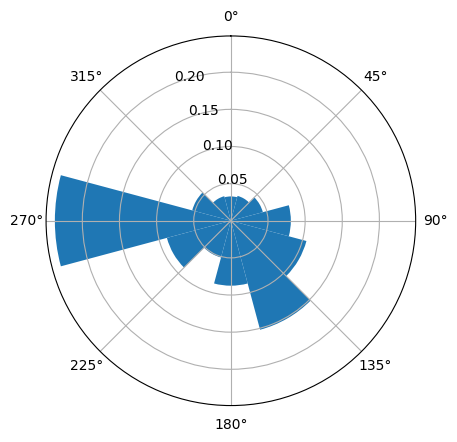

In [ ]:
# plot wind rose 
plt.figure(dpi=100)
site.plot_wd_distribution()

We now set up the two turbine types and define their basic paramenters such as diameter, hub height and CT curve. A `TurbineTypes` class is created to merge the turbine objects to then feed into the wind farm model as `WindTurbines` object.

In [ ]:
# Turbine types
turb_types = [0, 1]
names = ['V80', 'DTU10MW']
diameters = [V80().diameter(), DTU10MW().diameter()]
hub_heights = [V80().hub_height(), DTU10MW().hub_height()]
powerCtFunctions = [V80().powerCtFunction, DTU10MW().powerCtFunction]
n_types = len(turb_types)


# Merge turbine objects
class TurbineTypes(WindTurbines):
    def __init__(self):
        super().__init__(names, diameters, hub_heights, powerCtFunctions)

windTurbines = TurbineTypes()

In [ ]:
diameters

[80, 178.3]

In [ ]:
# Wind farm model 
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines)

We now set up the objective function and the `CostModelComponent`.

In [ ]:
# Objective function and cost model component

def wake_loss(x, y, type, **kwargs):
    '''Calculate the wake losses in %.'''
    simres = wfm(x, y, type=np.asarray(type, dtype=int), **kwargs)
    aep_ref = simres.aep().values.sum()
    aep_nowake = simres.aep(with_wake_loss=False).values.sum()
    loss = 100 * (aep_nowake - aep_ref) / aep_nowake
    return loss


cost_comp = CostModelComponent(input_keys=[('x', wt_x),('y', wt_y)],
                                          n_wt=n_wt,
                                          cost_function=wake_loss,
                                          objective=True,
                                          maximize=False,
                                          output_keys=[('Wake losses', 0)],
                                          output_unit='%',
                                          additional_input= [(topfarm.type_key, np.ones(n_wt, dtype=int))]
                                          )

#### Optimization set up

The first layer of the optimization takes the turbine positions and design variables as well as the spacing and boundary constraints.

In [ ]:
# Layout component (1st layer of the optimization)
layout_problem = TopFarmProblem(design_vars={topfarm.x_key: wt_x,
                                             topfarm.y_key: wt_y},
                                cost_comp=cost_comp,
                                driver=EasyScipyOptimizeDriver(maxiter=30, tol=1e-2, disp=False),
                                constraints=[SpacingTypeConstraint(3*np.asarray(diameters)),
                                              CircleBoundaryConstraint([0, 0], 600)],
                                plot_comp=NoPlot(),
                                expected_cost=1,
                                ext_vars={topfarm.type_key: np.zeros(n_wt, dtype=int)}, 
                                )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


The second layer utilizes the optimized layout to then find the optimal turbine types that satisfy the objective function.

In [ ]:
# topfarm main problem - uses the layout problem as component and turbine type as design variables (2nd layer)
problem = TopFarmProblem(design_vars={topfarm.type_key: ([1, 0, 1, 0, 1, 0, 1, 0 ,1], 0, int(n_types-1))},
                          cost_comp=layout_problem,
                          driver=EasyRandomSearchDriver(randomize_turbine_type, max_iter=30, disp=False)
                          )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


In [ ]:
# Run the optimization.
cost, state, recorder = problem.optimize()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking syste

INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: chec

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking syste

INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: chec

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking syste

INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: chec

In [ ]:
print(state['type'])

[0. 0. 1. 0. 0. 0. 0. 0. 0.]


Given that wind turbine type 0 (V80) has significantly smaller diameter and hub height, the solver selects mostly that type. The type 1 causes larger wake losses due to larger rotor diameter. However, a sweet spot can exist that allows to minimize the wake based on the hub height difference of type 1. 

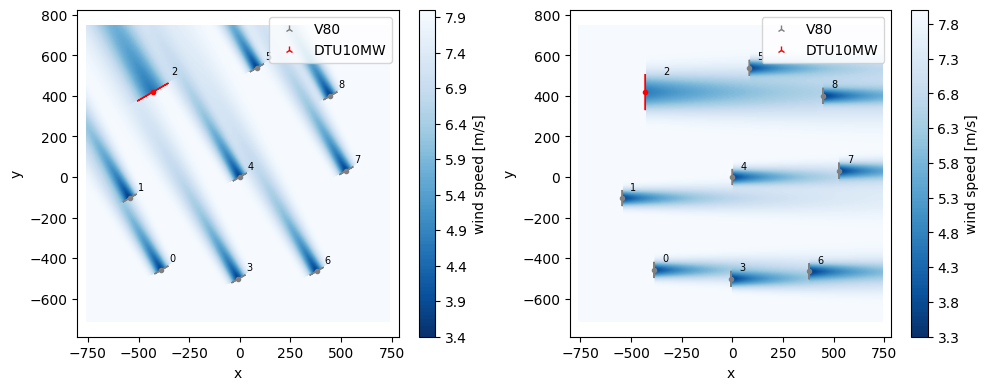

In [ ]:
# predominant wind directions are: 270 and 150 deg
wds = [150, 270]
wps = [8]
simres = wfm(state['x'], state['y'], type=state['type'], ws=wps, wd=wds)


fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=100, tight_layout=True)
for i in range(2):
    fm = simres.flow_map(wd=wds[i])
    fm.plot_wake_map(ax=ax[i])
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')

Text(0, 0.5, 'Wake loss [%]')

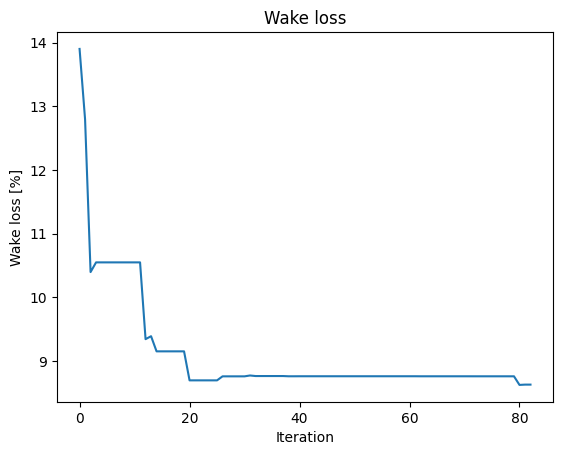

In [ ]:
fig, ax = plt.subplots()
ax.plot(recorder['Wake losses'])
ax.set_title('Wake loss')
ax.set_xlabel('Iteration')
ax.set_ylabel('Wake loss [%]')